# BL EThOS
#### Katriona Goldmann, November 2022

---

# Intro

The British Library operates its [Electronic Theses Online Service](https://ethos.bl.uk) or EThOS, that keeps track of PhD theses accepted at UK higher education institutions. The Library also makes public a [data set](https://data.bl.uk/ethos/) of metadata for all theses in their catalogue. Quoting their website,

>The EThOS dataset lists virtually all UK doctoral theses ever awarded, some 500,000 dating back to 1787. All UK HE institutions are included, but we estimate records are missing for around 10,000 titles (2%).

The latest version of the dataset is from October 2022. The data includes the title, year, author, institution, discipline for each thesis, as well as a link to a full record which may or may not include things like keywords or access to full texts.

---

## Analysis goals and outline 

In this notebook I explore this EThOS dataset to identify gender trends in UK academia. The notebook is structured roughly as follows:
- [x] Prepare the data for analysis

#### Gender analysis
- [x] Predict the gender of authors from their first name
- [ ] Predict supervisor genders

#### Supervisor network
- [ ] Create a network of supervision - how inter/intra-institutional are the networks? 

#### Buzz words
- [ ] Study trends in the popularities of individual words appearing in thesis titles
- [ ] Use a co-occurrence graph of words in thesis titles to detect academic fields, and score thesis titles on which field(s) they seem to belong to
- [ ] Use the above to study trends in the popularity of different academic fields

---

# 0. Setting up and preparing the data

## 0.1 Load in the data and import packages

First off, some imports of python libraries we'll be needing, and loading the data file into a pandas DataFrame. The script will automatically download the data file into the current working directory if it isn't there yet.

In [3]:
import os
import operator as opr
import scipy as sp
import numpy as np
import pandas as pd
import networkx as nx
import re
import gender_guesser.detector as gender
import community  # Network community finding
from matplotlib import pyplot as plt
import matplotlib.colors
import seaborn as sns
import networkx as nx
import plotly.graph_objects as go



from IPython.display import set_matplotlib_formats

In [4]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [12, 5]

# Set a consistent plotting style across the notebook using Seaborn.
sns.set_style("darkgrid")
sns.set_context("notebook")

Get the data from EThOS. The latest one which isn't embargoed in 202210. 

In [5]:
# Function to clean the NaN and incorrectly formatted data
def remove_na(df: pd.DataFrame, save: bool = True,
              filename: str = "Data/EThOS_CSV_202210.csv") -> pd.DataFrame:
    null_df = df[df["IR URL"].isnull()]
    for index, row in null_df.iterrows():
        new_row = []
        # Title
        new_row.append(row["Title"].split(",")[0])
        # DOI
        new_row.append(row["Title"].split(",")[1])
        # Author
        first_name = row["Title"].split(",")[2]
        second_name = row["DOI"][:-1]
        new_row.append(first_name + second_name)
        # Remaining columns
        colnames = [col for col in df.columns
                    if col not in ["Title", "DOI", "IR URL"]]
        new_row += row[colnames].tolist()
        df.loc[index] = new_row
    df = df.fillna(' ')
    if save:
        df.to_csv(f"cleaned_{filename}")
    return 

In [6]:
datafile = "EThOS_CSV_202210.csv"

print('Data/' + datafile)

Data/EThOS_CSV_202210.csv


In [95]:
datafile = "EThOS_CSV_202210.csv"

# Check if file not already downloaded
if not os.path.isfile('Data/' + datafile):
    # Download and/or unzip the data file from the EThOS website.
    # We need a couple more imports for this.
    import zipfile

    datazip = re.sub("csv", "zip", datafile)
    if not os.path.isfile('Data/' + datazip):
        import requests

        dataurl = "https://bl.iro.bl.uk/downloads/6c6aab6d-a8e1-4ed7-85e2-7963d2569f80?locale=en"
        with requests.Session() as s:
            headers = {
                "User-agent": "Mozilla/5.0 (X11; Linux i686; rv:64.0) Gecko/20100101 Firefox/64.0"
            }
            r = s.get(dataurl, headers=headers)
            with open('Data/' + datazip, "wb") as f:
                f.write(r.content)
    with zipfile.ZipFile('Data/' + datazip, "r") as z:
        z.extractall(".")

In [96]:
df = pd.read_csv(f"Data/cleaned_{datafile}", encoding="ISO-8859-2")

/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49454/2447538290.py:1: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(f"Data/cleaned_{datafile}", encoding="ISO-8859-2")


## 0.2 Inspect the data

To get an idea of what the rows in the DataFrame look like, here are some samples:

In [97]:
df.head()

,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL
0,0,Computation and measurement of turbulent flow ...,,"Loizou, Panos A.",https://isni.org/isni/0000000136122593,,University of Manchester,https://isni.org/isni/0000000121662407,1989,Thesis (Ph.D.),,Physical Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
1,1,Prolactin and growth hormone secretion in norm...,,"Prescott, R. W. G.",https://isni.org/isni/0000000134992122,,University of Newcastle upon Tyne,https://isni.org/isni/0000000104627212,1983,Thesis (Ph.D.),,Biological Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
2,2,Influence of strain fields on flame propagation,,"Mendes-Lopes, J. M. C.",https://isni.org/isni/0000000133937105,,University of Cambridge,https://isni.org/isni/0000000121885934,1983,Thesis (Ph.D.),Flame propagation can be highly influenced by ...,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
3,3,"Connectivity, flow and transport in network mo...",,"Robinson, Peter Clive",https://isni.org/isni/0000000135292822,,University of Oxford,https://isni.org/isni/0000000419368948,1984,Thesis (Ph.D.),In order to evaluate the safety of radioactive...,Physical Sciences,"Rae, John",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,http://ora.ox.ac.uk/objects/uuid:c61bf73b-b794...
4,4,The theory and implementation of a high qualit...,,"Lower, K. N.",https://isni.org/isni/0000000136133567,,University of Bristol,https://isni.org/isni/0000000419367603,1985,Thesis (Ph.D.),,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,


How many entries are we dealing with?: 

In [98]:
set(df['Qualification'])

{' ',
 '(Ph.D.)',
 ')',
 '.)',
 '.D.)',
 '2 vols',
 '2 vols: Thesis (M.D.)',
 '2004',
 '3 vols: Thesis (M.D.)',
 '>D thesis',
 'Aberdeen University.',
 'BDA thesis',
 'BEd thesis',
 'BSc Thesis.',
 'BSc. thesis.',
 'Balliol College',
 'Bangor University, 2007',
 'Bangor University, 2008',
 'Bangor University, 2009',
 'Bangor, 1987',
 'Birmingham University.',
 'BruneI University, 2009',
 'Brunel University, 2006',
 'Brunel University, 2007',
 'Brunel University, 2008',
 'Brunel, 2008',
 'Business School',
 'CHRIST CHURCH',
 'Cambridge University.',
 'Ch.M',
 'Christ Church College',
 'City University, 2007',
 'Clin.Psy.D.))',
 'ClinPsyD',
 'College of Art',
 'Computing Laboratory',
 'D B A',
 'D Clin Psych',
 'D Clin Psychol.',
 'D ED',
 'D ED Psych',
 'D Ed',
 'D Ed Psych',
 'D Ed Psychol.',
 'D Ed--Sheffield, 2007',
 'D Ed--Sheffield, 2008',
 'D Ed--Sussex, 2008',
 'D Eng',
 'D Eng--Manchester, 2008',
 'D M',
 'D Med',
 'D Med--Manchester, 2008',
 'D Musical Arts',
 'D NSc.thesis',
 

In [99]:
print(df.shape[0])

610535


Data is loaded...so let's query it and search for the ETHoS contributors:

In [100]:

df.loc[df['Title'].str.contains('|'.join(['Beds']))]


,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL
43391,43391,Sedimentology of the Dalton Beds and the Park ...,,"Abdel Aziz, Abdel Aziz Abdel Rahman",https://isni.org/isni/0000000133892883,,University of Manchester,https://isni.org/isni/0000000121662407,1989,Thesis (Ph.D.),,Physical Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
79924,79924,Studies on the flora of the Reading Beds (Uppe...,,"Crane, Peter Robert",https://isni.org/isni/0000000133954941,,University of Reading,https://isni.org/isni/0000000404579566,1981,Thesis (Ph.D.),,Biological Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
207150,207150,The Behaviour of Liquid Fluidized Beds Contain...,,"Al-Dibouni, M. R.",https://isni.org/isni/0000000134053547,,University College London (University of London),https://isni.org/isni/0000000121901201,1975,Thesis (Ph.D.),,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
207287,207287,The Effects of Drugs and Nerve Stimulation on ...,,"Al-Jubouri, M.",https://isni.org/isni/0000000134064836,,King's College London (University of London),https://isni.org/isni/0000000123226764,1975,Thesis (Ph.D.),,Medicine & Health,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
207638,207638,Sedimentological and palaeoenvironmental studi...,,"Amiri-Garroussi, Kourosh",https://isni.org/isni/0000000134196521,,University of Oxford,https://isni.org/isni/0000000419368948,1978,Thesis (Ph.D.),Planorbis to Turneri Zone sedimentary rocks we...,Physical Sciences,"Hallam, Anthony",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,http://ora.ox.ac.uk/objects/uuid:cff8f820-9b8b...
208992,208992,Resistance to Flow in Rivers with Stony Beds,,"Bathurst, J. C.",https://isni.org/isni/0000000134512491,,University of East Anglia,https://isni.org/isni/0000000110927967,1977,Thesis (Ph.D.),,Physical Sciences,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
209522,209522,Heat Transfer in Fluidised Beds,,"Bhattacharya, S. C.",https://isni.org/isni/0000000134632979,,University of Cambridge,https://isni.org/isni/0000000121885934,1976,Thesis (Ph.D.),,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
211023,211023,Quantitative Studies of the Mixing and Segrega...,,"Cheung, L. Y. L.",https://isni.org/isni/0000000135433576,,University College London (University of London),https://isni.org/isni/0000000121901201,1974,Thesis (Ph.D.),,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
211638,211638,Mass Transfer in Two Phase Co-Current Flow in ...,,"Colquhoun-Lee, I.",https://isni.org/isni/0000000135609279,,University of Salford,https://isni.org/isni/0000000404605971,1976,Thesis (Ph.D.),,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,
213173,213173,Hydrodynamics and Mass Transfer Studies in Thr...,,"Dhanuka, V.",https://isni.org/isni/0000000134232465,,University of Salford,https://isni.org/isni/0000000404605971,1978,Thesis (Ph.D.),,Engineering & Technology,,,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,


In [101]:

df.loc[df['Author'].str.contains('|'.join(['Fenton, I', 'Hauru, M', 'Goldmann, K', 'Chan, Ryan', 
                                           'Nanni, F', 'Beavan, D', 'Rangel Smith']))]

,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL
476371,476371,Environmental controls on planktonic foraminif...,https://doi.org/10.25560/53930,"Fenton, Isabel",https://isni.org/isni/0000000464226869,,Imperial College London,https://isni.org/isni/0000000121889740,2016,Thesis (Ph.D.),Planktonic foraminifera are unicellular zoopla...,Biological Sciences,"Purvis, Andy",Natural Environmental Research Council,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://doi.org/10.25560/53930


Most team members completed doctorates outside the UK

In [102]:
df.loc[df['Supervisor(s)'].str.contains('|'.join(['Pitzalis, Constantino', 'Lewis, Myles']))]

,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL


---

#  1. Author Gender Analysis

## 1.1 Extract author names

In [103]:
df['Surname'] = df.apply(lambda row : row['Author'].split(",")[0].strip(), axis = 1)
df['Forenames'] = df.apply(lambda row : re.sub(".*,", "", str(row['Author'])), axis = 1)
df['Firstname'] = df.apply(lambda row : row['Forenames'].strip().split(" ")[0].strip(), axis = 1)

In [104]:
df[['Author', 'Surname', 'Firstname']].head()

,Author,Surname,Firstname
0,"Loizou, Panos A.",Loizou,Panos
1,"Prescott, R. W. G.",Prescott,R.
2,"Mendes-Lopes, J. M. C.",Mendes-Lopes,J.
3,"Robinson, Peter Clive",Robinson,Peter
4,"Lower, K. N.",Lower,K.


## 1.1 Predict gender from first name

We will use [gender-guesser](https://pypi.org/project/gender-guesser/) to predict an individuals gender from their first name. This can match data for about 40,000 Names from a database.

Lets test is out on two names we know the gender for, and with a couple of different spellings to really test the system:

In [105]:
gd = gender.Detector()

list_of_names = [['Katriona', 'Katrina', 'Catriona', 'Caitriona','Catarina', 'Caterina', 'Catrina'], 
                ['Alister', 'Allister', 'Alastor', 'Alasdair']]

print('\n'.join([' '.join([x, 'is classed', gd.get_gender(x)]) for x in list_of_names[0]]), '\n-----')
print('\n'.join([' '.join([x, 'is classed', gd.get_gender(x)]) for x in list_of_names[1]]))

Katriona is classed female
Katrina is classed female
Catriona is classed female
Caitriona is classed unknown
Catarina is classed female
Caterina is classed female
Catrina is classed female 
-----
Alister is classed male
Allister is classed male
Alastor is classed unknown
Alasdair is classed male


In this case it works pretty well - just issues with unusual spellings. 

In [106]:
df['Predicted_gender'] = df.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)
gender_count = df.Predicted_gender.value_counts()

print(gender_count)

male             246364
unknown          174602
female           159568
andy              14148
mostly_female      8303
mostly_male        7550
Name: Predicted_gender, dtype: int64


Visualise these predictions

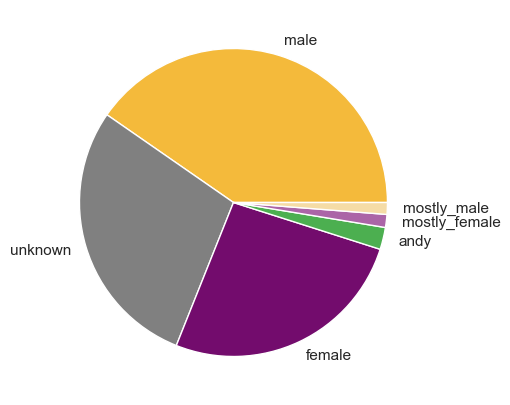

In [107]:
colours = {'unknown': 'grey', 'andy': '#4CAF50', 
            'female': '#730C6D', 'male': '#F4BA3B', 
            'mostly_female': '#ab65a7', 'mostly_male': '#f5dca6'}
colours = pd.Series(data=colours, index=list(gender_count.index))
            
plt.pie(gender_count, labels = list(gender_count.index), colors=colours)
plt.show() 

And if we repeat this but dropping initialised names? 

male             246364
female           159568
unknown           77343
andy              14148
mostly_female      8303
mostly_male        7550
Name: Predicted_gender, dtype: int64


/var/folders/c2/_b9mpch10xs9cgrc8sq6fhfm0000gr/T/ipykernel_49454/4146280149.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_fullname['Predicted_gender'] = df_fullname.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)


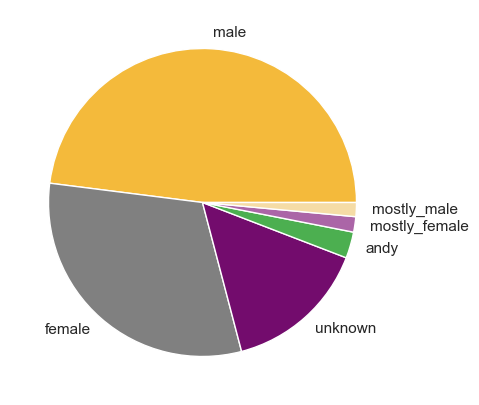

In [108]:
# Remove initialised first names
s = [len(re.sub("\\.", "", str(x) )) > 1 for x in df['Firstname'] ]
df_fullname = df.loc[s]

# Predict gender on _this_
df_fullname['Predicted_gender'] = df_fullname.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)
gender_count = df_fullname.Predicted_gender.value_counts()

print(gender_count)

plt.pie(gender_count, labels = list(gender_count.index), colors=colours)
plt.show() 


If we break this down into those confirmed as male and female only.  

In [109]:
df_gender = df.loc[df["Predicted_gender"].isin(["female", "male"])]

print('We lose', df.shape[0] - df_gender.shape[0], 'rows')

We lose 204603 rows


## 1.2 Publications by gender over time

Let's include those initialised...but as a subset of unknown. As this in itself is quite interesting - perhaps shows how authors think about gender in academia. 

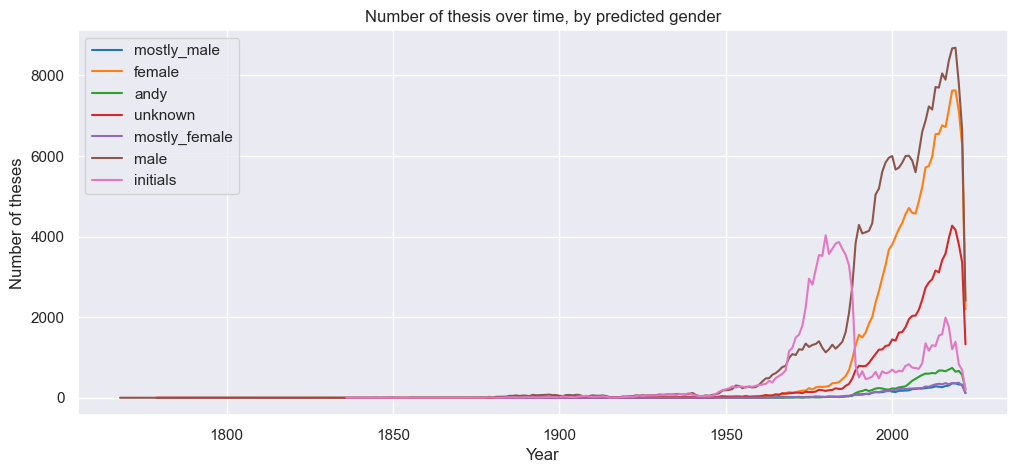

In [110]:
# Only include those with year provided
df_time = df.loc[df['Date'] != ' ']

# Label those just initialised
s = [len(re.sub("\\.", "", str(x) )) == 1 for x in df_time['Firstname'] ]
df_time.loc[s, ["Predicted_gender"]] = 'initials'

# Loop through each gender and count number over time
for gen in set(df_time["Predicted_gender"]): 
    counts_per_year = df_time.loc[df_time["Predicted_gender"] == gen]
    counts = counts_per_year['Date'].astype(int).value_counts().sort_index()
    plt.plot(counts.index, counts, label=gen)

plt.xlabel('Year')
plt.ylabel('Number of theses')
plt.title('Number of thesis over time, by predicted gender')
plt.legend()
plt.show()


Interestingly the initialisms drop off as the number of females shoots up.....coiincidence? What does initials + female look like? 

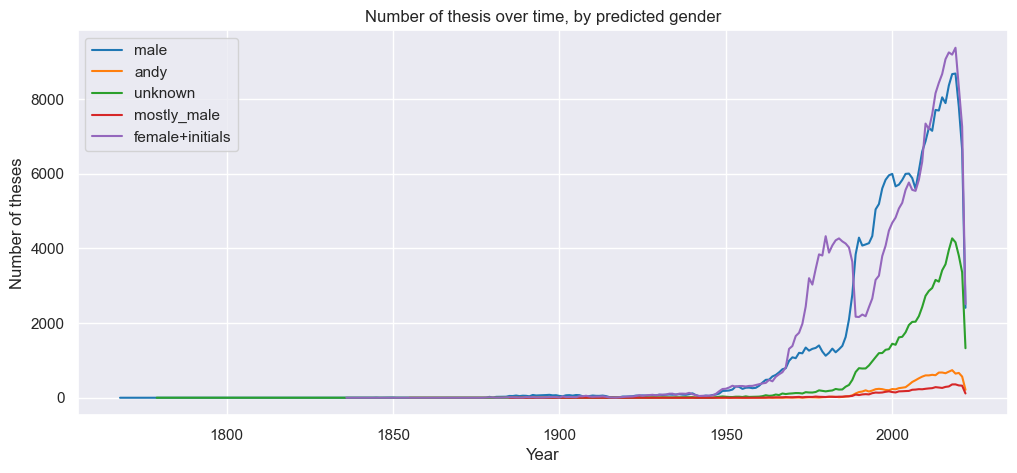

In [111]:
# Loop through each gender and count number over time
for gen in ['male', 'andy', 'unknown', 'mostly_male']: 
    counts_per_year = df_time.loc[df_time["Predicted_gender"] == gen]
    counts = counts_per_year['Date'].astype(int).value_counts().sort_index()
    plt.plot(counts.index, counts, label=gen)


# What about initials and female? 
counts_per_year = df_time.loc[df_time["Predicted_gender"].isin(['female', 'initials', 'mostly_female']) ]
counts = counts_per_year['Date'].astype(int).value_counts().sort_index()
plt.plot(counts.index, counts, label='female+initials')

plt.xlabel('Year')
plt.ylabel('Number of theses')
plt.title('Number of thesis over time, by predicted gender')
plt.legend()
plt.show()

## 1.3 Gender Breakdown by Discipline

In [112]:
df2 = df_gender.loc[df["Subject Discipline"] != ' ']

all_subject = df2['Subject Discipline'].value_counts()
male = df2.loc[df2["Predicted_gender"].isin(["male"])]['Subject Discipline'].value_counts().reindex(all_subject.index)
male_ratio = (male/all_subject).sort_values(ascending=False)

all_subject = all_subject.reindex(male_ratio.index)
male = male.reindex(male_ratio.index)
female = df2.loc[df2["Predicted_gender"].isin(["female"])]['Subject Discipline'].value_counts().reindex(male_ratio.index)

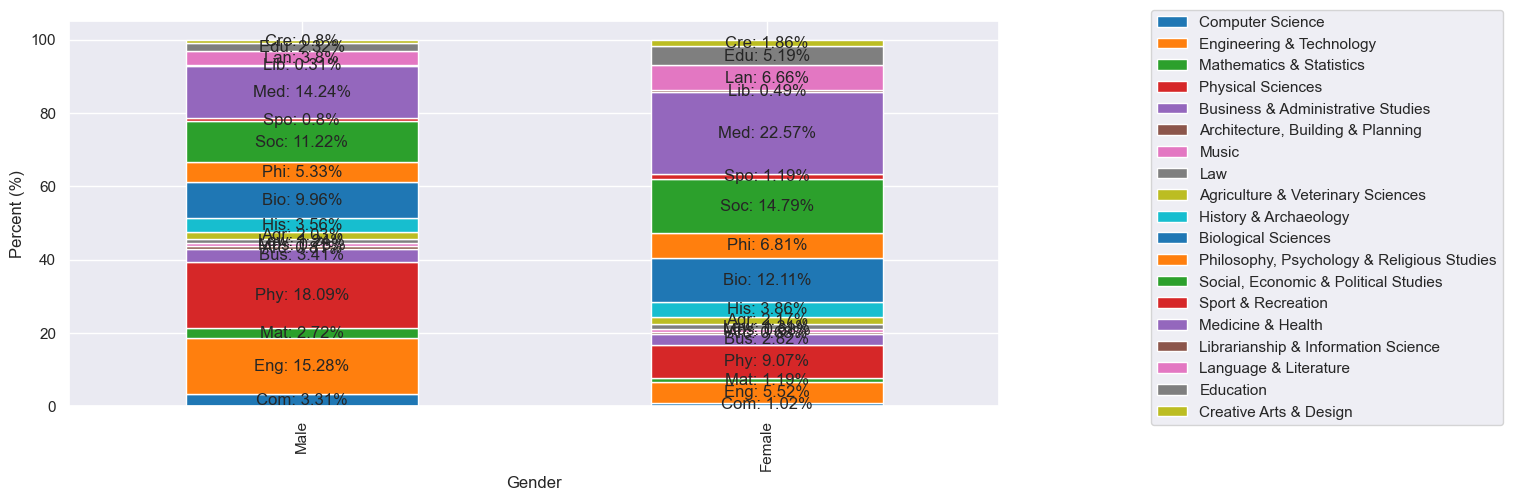

In [113]:
cols = ['Gender']
cols.extend(list(male.index))

df_discipline = pd.DataFrame(columns=cols)

m = ['Male']
m.extend(100*male.values/sum(male))
f = ['Female']
f.extend(100*female.values/sum(female))

df_discipline.loc[len(df_discipline)] = m
df_discipline.loc[len(df_discipline)] = f

ax = df_discipline.plot.bar(x='Gender', stacked='True', ylabel='Percent (%)')
ax.legend(bbox_to_anchor=(1.55, 1.05))

i=0
for c in ax.containers:
    l1 = male.index[i][0:3]
    i=i+1
    # Optional: if the segment is small or 0, customize the labels
    labels = [''.join([l1, ': ', str(round(v.get_height(), 2)) if v.get_height() > 0 else '', '%']) for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')


As I would predict, the largest proportion of female theses are in Medicine and Biology; whereas for males it in physics and engineering. 

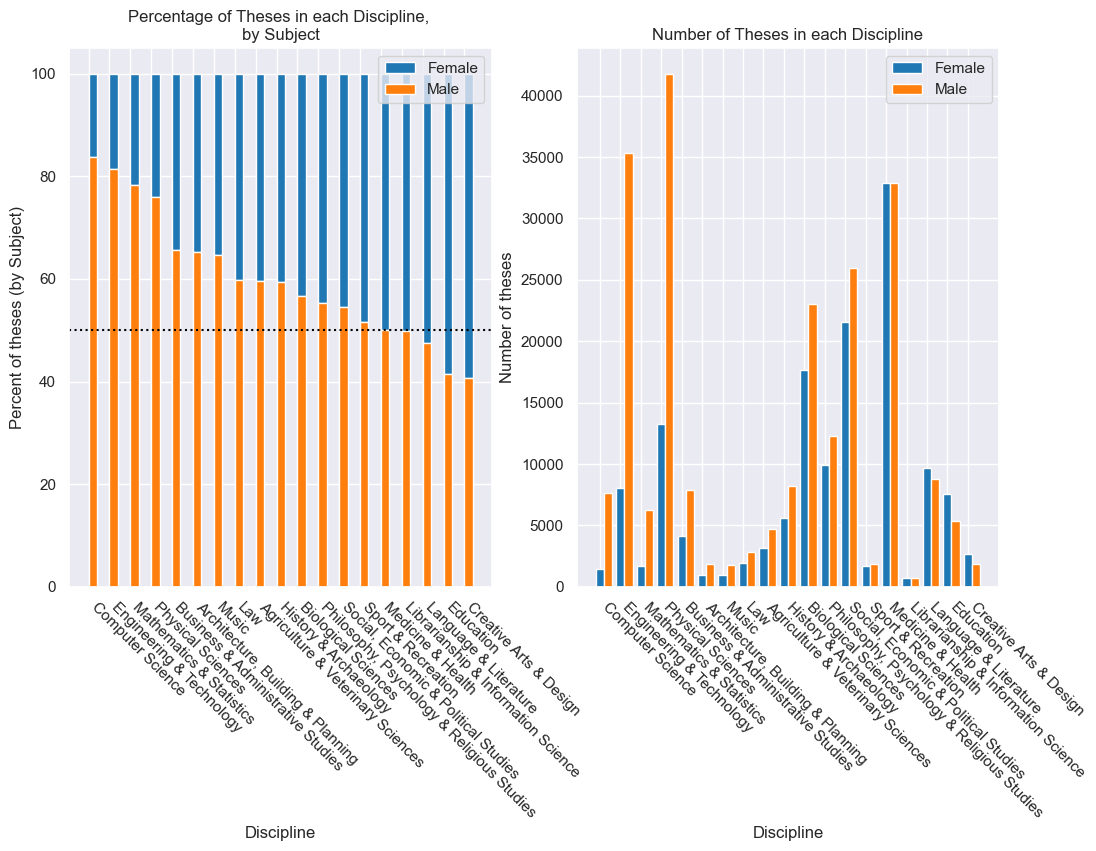

In [114]:
plt.rcParams['figure.figsize'] = [12, 7]

X_axis = np.arange(len(male))
fig, (axs1, axs2) = plt.subplots(1, 2)

# Percentages, by subject
axs1.bar(X_axis, 100*female/all_subject, 0.4, label = 'Female', bottom=100*male/all_subject)
axs1.bar(X_axis, 100*male/all_subject, 0.4, label = 'Male')
axs1.set_title("Percentage of Theses in each Discipline, \nby Subject")
axs1.set_xticks(X_axis-0.2, list(male.index), rotation=-45, ha='left')
axs1.axhline(y = 50, color = 'black', linestyle = ':')
axs1.set_xlabel("Discipline")
axs1.set_ylabel("Percent of theses (by Subject)")
axs1.legend()

# Raw numbers
axs2.bar(X_axis-0.2, female, 0.4, label = 'Female')
axs2.bar(X_axis+0.2, male, 0.4, label = 'Male')
axs2.set_xticks(X_axis-0.2, list(male.index), rotation=-45, ha='left')
axs2.set_xlabel("Discipline")
axs2.set_ylabel("Number of theses")
axs2.set_title("Number of Theses in each Discipline")
axs2.legend()

## 1.4 Gender Breakdown by Institution

In [115]:
df_inst = df_gender.loc[df["Institution"] != ' ']

all_subject = df_inst['Institution'].value_counts()
male = df_inst.loc[df_inst["Predicted_gender"].isin(["male"])]['Institution'].value_counts().reindex(all_subject.index)
male_ratio = (male/all_subject).sort_values(ascending=False)

all_subject = all_subject.reindex(male_ratio.index)
male = male.reindex(male_ratio.index)
female = df_inst.loc[df_inst["Predicted_gender"].isin(["female"])]['Institution'].value_counts().reindex(male_ratio.index)

In [116]:
s = [x for x in list(male.index) if re.search('University of Edinburgh|Queen Mary', x)]
100*male[s]/all_subject[s]

University of Edinburgh             66.394266
Queen Mary, University of London    58.404711
Name: Institution, dtype: float64

Let's print the worst (>65% one gender)

In [117]:
temp = male/all_subject 
matches = temp[(temp<0.35) | (temp>0.65)]

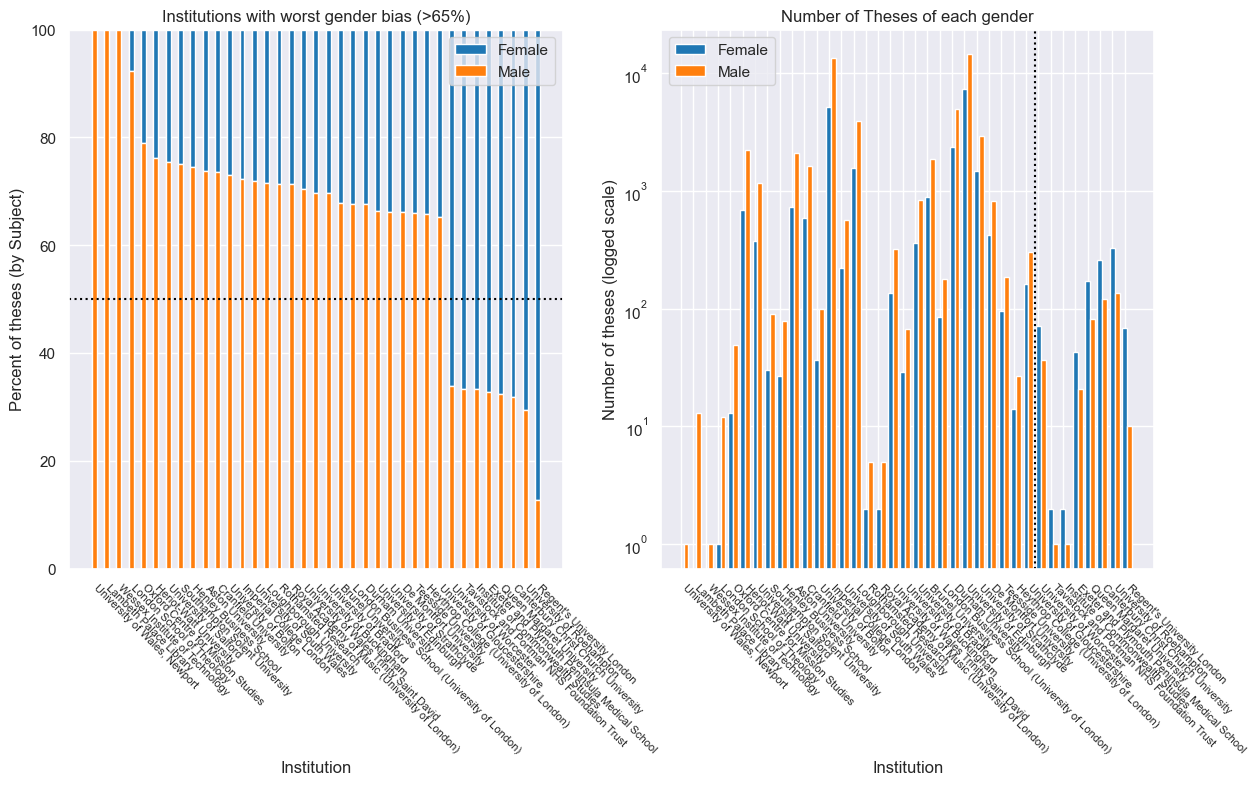

In [118]:
plt.rcParams['figure.figsize'] = [14, 7]

t1 = male[matches.index]/all_subject[matches.index]

X_axis = np.arange(len(t1))
fig, (axs1, axs2) = plt.subplots(1, 2)

# Percentage of each gender for worst offenders
axs1.bar(X_axis, 100*female[matches.index]/all_subject[matches.index], 0.4, label = 'Female', bottom=100*t1)
axs1.bar(X_axis, 100*t1, 0.4, label = 'Male')
axs1.set_title("Institutions with worst gender bias (>65%)")
axs1.set_xticks(X_axis-0.2, list(t1.index), rotation=-45, ha='left', size=8)
axs1.axhline(y = 50, color = 'black', linestyle = ':')
axs1.set_xlabel("Institution")
axs1.set_ylabel("Percent of theses (by Subject)")
axs1.legend()

# Raw numbers
axs2.bar(X_axis-0.2, female[matches.index], 0.4, label = 'Female')
axs2.bar(X_axis+0.2, male[matches.index], 0.4, label = 'Male')
axs2.set_xticks(X_axis-0.2, list(t1.index), rotation=-45, ha='left', size=8)
axs2.set_yscale('log',base=10) 
axs2.set_xlabel("Institution")
axs2.axvline(x=28.5, color = 'black', linestyle = ':')
axs2.set_ylabel("Number of theses (logged scale)")
axs2.set_title("Number of Theses of each gender")
axs2.legend(loc='upper left')

---

# 2. Number of supervisors/supervisees

In [119]:
df_supervisor = df.loc[df['Supervisor(s)'] != ' ']
df_supervisor = df_supervisor.reset_index()

print(' '.join(['Dropping', str(df.shape[0] - df_supervisor.shape[0]), 'rows']))

Dropping 467339 rows


In [120]:
def strip_split(input_string):
    split_list = str(input_string).split(';')
    stripped_list = [x.strip() for x in split_list]
    return stripped_list

all_sups = df_supervisor.apply(lambda row : strip_split(row["Supervisor(s)"]), axis = 1)
number_sups = df_supervisor.apply(lambda row : len(str(row["Supervisor(s)"]).split(';')), axis = 1)


How many supervisors to people have? 

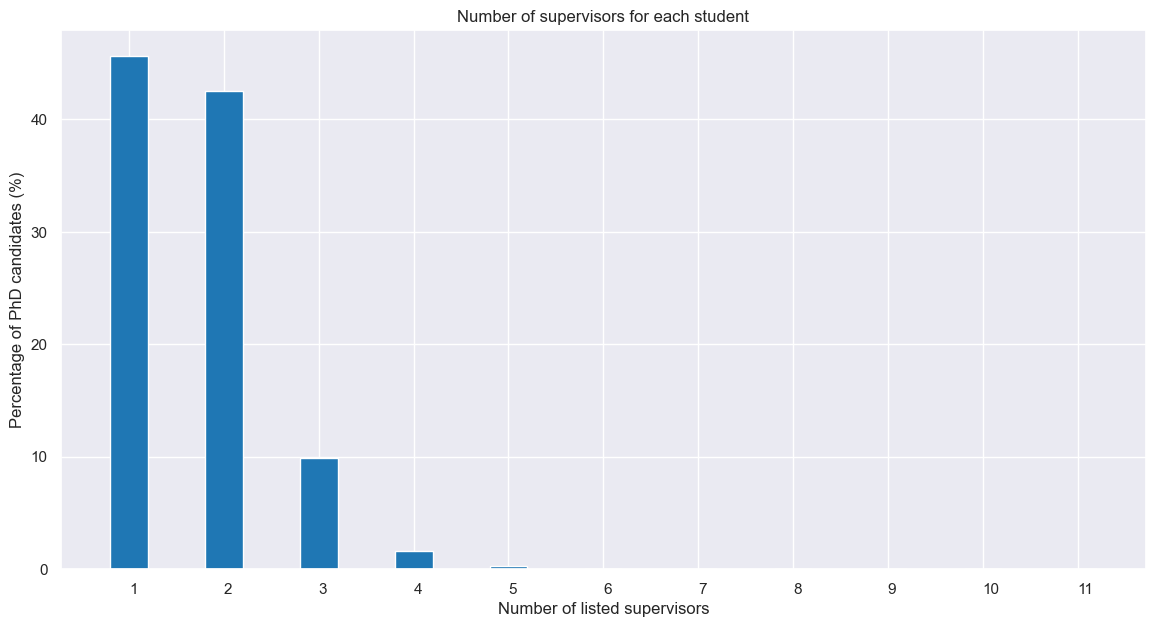

In [121]:
plt.bar(number_sups.value_counts().index, 100*number_sups.value_counts()/len(number_sups), 0.4)
plt.title("Number of supervisors for each student")
plt.xticks(range(1,12), range(1,12), ha='left')
plt.xlabel('Number of listed supervisors')
plt.ylabel("Percentage of PhD candidates (%)")
plt.show()

So most people have 1-3 supervisors, as we would expect, however some people have up to 11 (😱). This seems like a lot, but I've checked some of the cases and it seems that this is true according to the website, but when you pull off the pdfs typically only 3 are actual supervisors. One example:

In [122]:
all_sups.loc[number_sups == 11]
print(all_sups[43664])
print(df_supervisor['Author'][43664])

['Mar-Molinero, Clare', 'Armbruster, Heidemarie', 'Campbell, Tony', 'Quince, Eleanor', 'Dinneen, Mark A.', 'Corkill, D. J.', 'Devis-Rozental, Camila', 'Meyer, Heather-Anne', 'Fleming, David, Andrew', 'Robinson, Stephen', 'del Castillo, Rosario']
Devis, Esteban


So how many supervisors supervise multiple students? 

In [123]:
supervision_count = [item for sublist in all_sups for item in sublist]
supervision_count = pd.Series(supervision_count).value_counts()
print(supervision_count)

Darzi, Ara            91
Neville, Anne         81
Woods, Kevin          79
Yang, Guang-Zhong     78
Thompson, John        77
                      ..
Peeling, R. W.         1
Simmons, C.            1
Wills, B.              1
Edmunds, John          1
Paladini, Stefania     1
Length: 82157, dtype: int64


Wow! some people are notorious supervisors. Let's check out the main culprits: those with over 50 supervisions:


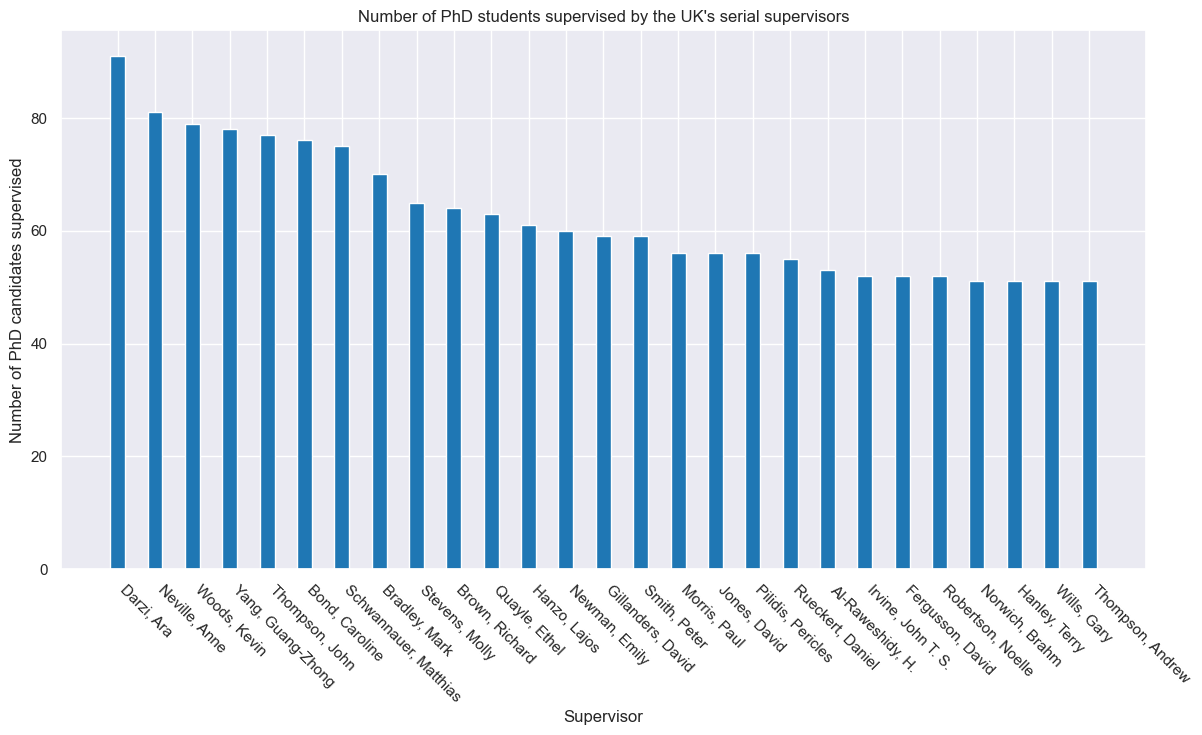

In [124]:
top_supervision_count = supervision_count.loc[supervision_count > 50]

plt.bar(top_supervision_count.index, top_supervision_count, 0.4)
plt.title("Number of PhD students supervised by the UK's serial supervisors")
plt.xticks(ha='left', rotation=-45)
plt.xlabel('Supervisor')
plt.ylabel("Number of PhD candidates supervised")
plt.show()

A quick good search confirms that these are indeed BNOCs. 

In [125]:
df.loc[df['Supervisor(s)'].str.contains('Neville, Anne')]

,Unnamed: 0,Title,DOI,Author,Author ISNI,ORCID,Institution,Institution ISNI,Date,Qualification,Abstract,Subject Discipline,Supervisor(s),Funder(s),EThOS URL,IR URL,Surname,Forenames,Firstname,Predicted_gender
263225,263225,Barium sulphate formation kinetics and inhibit...,,"Mavredaki, Eleftheria",https://isni.org/isni/000000042681706X,,University of Leeds,https://isni.org/isni/0000000419368403,2009,Thesis (Ph.D.),This study refers to experimental work and ana...,Engineering & Technology,"Neville, Anne",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/21106/,Mavredaki,Eleftheria,Eleftheria,female
263226,263226,Erosion-corrosion of marine alloys,,"Meng, Hang",https://isni.org/isni/000000042681714X,,University of Leeds,https://isni.org/isni/0000000419368403,2009,Thesis (Ph.D.),"Marine alloys such as stainless steels, copper...",Engineering & Technology,"Neville, Anne ; Hu, Xinming",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/12739/,Meng,Hang,Hang,andy
267922,267922,Erosion-corrosion mitigation using chemicals,,"Chun, Wang",https://isni.org/isni/0000000426852367,,University of Leeds,https://isni.org/isni/0000000419368403,2007,Thesis (Ph.D.),The presence of entrained sand in oil and gas ...,Engineering & Technology,"Neville, Anne",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/747/,Chun,Wang,Wang,andy
283714,283714,The lubrication of aluminium-silicon surfaces ...,,"Burkinshaw, Michael Stephen",https://isni.org/isni/000000042697257X,,University of Leeds,https://isni.org/isni/0000000419368403,2010,Thesis (Ph.D.),Even though research into aluminium-silicon al...,Engineering & Technology,"Neville, Anne ; Morina, Ardian",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/21110/,Burkinshaw,Michael Stephen,Michael,male
299966,299966,A novel electrochemical technique for mineral ...,,"Teh, Tong H.",https://isni.org/isni/0000000427121494,,Heriot-Watt University,https://isni.org/isni/0000000106567444,2011,Thesis (Ph.D.),Mineral scaling poses a far greater problem to...,Engineering & Technology,"Neville, Anne ; Thomson, Gillian",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,http://hdl.handle.net/10399/2488,Teh,Tong H.,Tong,andy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
586058,586058,The effect of gasoline as a contaminant on the...,,"Nejadhamzeeigilani, Mahdiyar",https://isni.org/isni/0000000506714714,https://orcid.org/0000000173305305,University of Leeds,https://isni.org/isni/0000000419368403,2021,Thesis (Ph.D.),Requirements within the automotive industry fo...,,"Morina, Ardian ; Neville, Anne ; Kosarieh, Sha...",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/29356/,Nejadhamzeeigilani,Mahdiyar,Mahdiyar,unknown
591631,591631,Corrosion behaviour of CoCrMo in simulated bio...,,"Thornley, Blake John",https://isni.org/isni/0000000506640655,https://orcid.org/0000000271901055,University of Leeds,https://isni.org/isni/0000000419368403,2021,Thesis (Ph.D.),,Engineering & Technology,"Beadling, Andrew Robert ; Bryant, Michael ; Ne...",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/29584/,Thornley,Blake John,Blake,mostly_male
604456,604456,The development of a semi-deterministic wear m...,,"Gong, Yajing",,,University of Leeds,https://isni.org/isni/0000000419368403,2021,Thesis (Ph.D.),,,"Neville, Anne ; Morina, Ardian ; Ghanbarzadeh,...",,https://ethos.bl.uk/OrderDetails.do?uin=uk.bl....,https://etheses.whiterose.ac.uk/30209/,Gong,Yajing,Yajing,unknown
604480,604480,Pitting corrosion behaviour of CRAs in COĂ˘ÂÂ...,,"Alhebsi, Mohamed Abdulla Saeed Bin Qasim",https://isni.org/isni/0000000507363442,,University of Leeds,https://isni.org/isni/0000000419368403,2021,Thesis (Ph.D.),With the increasing global demand for petroleu...,,"Barker, Richard ; Neville, Anne ; Pessu, Frede...",,https://ethos.bl.uk/Or

---

# 3. Supervisor network analysis

Convert supervision to long format: 

In [126]:
df_supervisor.columns

Index(['index', 'Unnamed: 0', 'Title', 'DOI', 'Author', 'Author ISNI', 'ORCID',
       'Institution', 'Institution ISNI', 'Date', 'Qualification', 'Abstract',
       'Subject Discipline', 'Supervisor(s)', 'Funder(s)', 'EThOS URL',
       'IR URL', 'Surname', 'Forenames', 'Firstname', 'Predicted_gender'],
      dtype='object')

## How shall we deal with 

In [130]:
# Any identical titles
df_dups = df_supervisor['Title'].value_counts()


Doctorate in Clinical Psychology : main research portfolio                                                                26
Portfolio of compositions                                                                                                 20
Research portfolio submitted in part fulfilment of the requirements for the degree of Doctorate in Clinical Psychology    18
Portfolio of original compositions                                                                                        18
Essays in financial economics                                                                                             10
                                                                                                                          ..
Some problems in eigenfunction expansions                                                                                  2
Towards the total synthesis of domoic acid and the isodomoic acids                                                         2


In [ ]:
df_dups = df_dups[df_dups > 1]

print(df_dups)

In [128]:
supervisor_network = pd.DataFrame([(k, y) for k, v in enumerate(all_sups) for y in v], columns=['type','Supervisor'])

supervisor_network['Author'] = df_supervisor['Author'][supervisor_network['type'].values].values
supervisor_network['Institution'] = df_supervisor['Institution'][supervisor_network['type'].values].values

supervisor_network['Title'] = df_supervisor['Title'][supervisor_network['type'].values].values
supervisor_network['Discipline'] = df_supervisor['Subject Discipline'][supervisor_network['type'].values].values
supervisor_network['Supervisor role'] = supervisor_network.groupby((supervisor_network['type'] != supervisor_network['type'].shift(1)).cumsum()).cumcount()+1

supervisor_network['Number of Supervisors'] = supervisor_network.groupby('Author')['Author'].transform('size')
supervisor_network['Number of Supervisees'] = supervisor_network.groupby('Supervisor')['Supervisor'].transform('size')

supervisor_network.head()

,type,Supervisor,Author,Institution,Title,Discipline,Supervisor role,Number of Supervisors,Number of Supervisees
0,0,"Rae, John","Robinson, Peter Clive",University of Oxford,"Connectivity, flow and transport in network mo...",Physical Sciences,1,1,16
1,1,"Trew, Karen","Gallagher, Anthony",Queen's University Belfast,Social identity and ideology in intergroup con...,"Philosophy, Psychology & Religious Studies",1,1,1
2,2,"Gough, Brendan","Day, Katy L.",Sheffield Hallam University,Women and alcohol : contemporary discourses ar...,"Social, Economic & Political Studies",1,3,3
3,2,"Mcfadden, Majella","Day, Katy L.",Sheffield Hallam University,Women and alcohol : contemporary discourses ar...,"Social, Economic & Political Studies",2,3,2
4,2,"Mac an Ghaill, Mairtin","Day, Katy L.",Sheffield Hallam University,Women and alcohol : contemporary discourses ar...,"Social, Economic & Political Studies",3,3,1


In [ ]:
# Save this object
import pickle

supervisor_network.to_pickle('./Data/supervisor_data.pickle')

## 3.1 Same Name Issue

The issue with creating networks linked by name is that there are many individuals with the same name (e.g. David Jones). If we look at this in the author/student case, we would assume very few individuals have > 1 PhD. A little online scrolling suggests that of all PhD students < 1% have multiple doctorates (although no hard data on this). 

Perhaps we can individualise authors using their institution + discipline, however this is not really possible for the supervisors as they may have cross-discipline, inter-institution supervision. 


In [ ]:
# Remove initialised first names
s = [len(re.sub("\\.", "", str(x) )) > 1 for x in df['Firstname'] ]
df_dups = df.loc[s]


# Which names are duplicated?
df_dups = df_dups['Author'].value_counts()
df_dups = df_dups[df_dups > 1]

In [ ]:
df_dups = df_dups.head(50)

X_axis = np.arange(len(df_dups))

# Percentages, by subject
plt.rc('axes', unicode_minus=False)
plt.bar(X_axis, df_dups, 0.4)
plt.title("Number of publications by name")
plt.xticks(X_axis, list(df_dups.index), rotation=-45, ha='left')
#plt.axhline(y = 50, color = 'black', linestyle = ':')
plt.xlabel("Name")
plt.ylabel("Number of PhDs published")
plt.show()

Even within institutions and disciplines names are not unique: 

In [ ]:
# Get the duplicated authors with institution and discipline
name_count = df.loc[df['Author'].isin(df_dups.index), ['Author', 'Institution', 'Subject Discipline']].value_counts()
print(name_count)

print('\nNumber of publications for all name+institution+discipline combinations:')
name_count.value_counts()

What about for the supervisors? Is it realistic to link them to institution? or discipline? or century? 

## 3.2 Creating a network

For now we are subsetting to author names who also supervise (and they supervise more than 1 student) in the field of medicine

In [ ]:
sub_sup_network = supervisor_network[['Author', 'Supervisor', 'Discipline', 
                                        'Number of Supervisees', 'Supervisor role']]

# Only authors who also go on to supervise in medicine
sub_sup_network = sub_sup_network.loc[sub_sup_network['Author'].isin(sub_sup_network['Supervisor'])]
sub_sup_network = sub_sup_network.loc[sub_sup_network['Discipline'].isin(['Medicine & Health'])]

# Multiple supervisees
sub_sup_network = sub_sup_network.loc[sub_sup_network['Number of Supervisees'] > 1]

print(supervisor_network.shape[0], sub_sup_network.shape[0])

Set up the network

In [ ]:
plt.rcParams['figure.figsize'] = [12, 12]

G = nx.DiGraph()

for  i, (x, y, sub, sup_n, sup_role) in sub_sup_network.head(100).iterrows():
    G.add_node(x, color='red',style='filled',fillcolor='blue',shape='square')
    G.add_node(y, color='red',style='filled',fillcolor='blue',shape='square')
    G.add_edge(x,y)

In [ ]:
# Discretise a continuous colour scale
from plotly.express.colors import sample_colorscale
from sklearn.preprocessing import minmax_scale

colors_ = list(range(1, 12))
discrete_colors = sample_colorscale('Bluered', minmax_scale(colors_))


In [ ]:
print(discrete_colors)

In [ ]:
#discrete_colors[0].convert("RGBA")

In [ ]:
#sub_sup_network.head()
order = [sub_sup_network['Supervisor role'].head(100).values -1] 

edge_cols = [discrete_colors[i] for i in order[0]]

Visualise the network (this can take some time for many nodes)

In [ ]:
nx.draw_spring(G, with_labels = False, font_size=14 , 
                node_size=200, edge_color='red')

What about if we try plotting with plotly

In [ ]:
pos = nx.spring_layout(G)

In [ ]:
# Set up the edges
def make_edge(x, y, text, width):
    return  go.Scatter(x         = x,
                       y         = y,
                       line      = dict(color = 'cornflowerblue'),
                       hoverinfo = 'text',
                       #text      = ([text]),
                       mode      = 'lines')

# For each edge, make an edge_trace, append to list
edge_trace = []
for edge in G.edges():  
  
    char_1 = edge[0]
    char_2 = edge[1]
    x0, y0 = pos[char_1]
    x1, y1 = pos[char_2]
    text   = char_1 + '--' + char_2 + ': '# + str(G.edges()[edge]['weight'])
        
    trace  = make_edge([x0, x1, None], [y0, y1, None], text, width=1)#, 
                        #width = 0.3*G.edges()[edge]['weight']**1.75)
    edge_trace.append(trace)

In [ ]:
# Set up the nodes
node_trace = go.Scatter(x         = [],
                        y         = [],
                        text      = [],
                        textposition = "top center",
                        textfont_size = 10,
                        mode      = 'markers+text',
                        hoverinfo = 'none',
                        marker    = dict(color = [],
                                         size  = [],
                                         line  = None))
# For each node in midsummer, get the position and size and add to the node_trace
for node in G.nodes():
    x, y = pos[node]
    node_trace['x'] += tuple([x])
    node_trace['y'] += tuple([y])
    node_trace['marker']['color'] += tuple(['cornflowerblue'])
    node_trace['marker']['size'] += tuple([1])
    node_trace['text'] += tuple(['<b>' + node + '</b>'])

In [ ]:
# Customize layout
layout = go.Layout(
    paper_bgcolor='rgba(0,0,0,0)', # transparent background
    plot_bgcolor='rgba(0,0,0,0)', # transparent 2nd background
    xaxis =  {'showgrid': False, 'zeroline': False}, # no gridlines
    yaxis = {'showgrid': False, 'zeroline': False}, # no gridlines
)
# Create figure
fig = go.Figure(layout = layout)
# Add all edge traces
for trace in edge_trace:
    fig.add_trace(trace)
# Add node trace
fig.add_trace(node_trace)
# Remove legend
fig.update_layout(showlegend = False)
# Remove tick labels
fig.update_xaxes(showticklabels = False)
fig.update_yaxes(showticklabels = False)
# Show figure
fig.show()

---

# 4. Reinterate the duplicated names problem

In [ ]:
supervisor_network['Surname'] = supervisor_network.apply(lambda row : row['Supervisor'].split(",")[0].strip(), axis = 1)
supervisor_network['Forenames'] = supervisor_network.apply(lambda row : re.sub(".*,", "", str(row['Supervisor'])), axis = 1)
supervisor_network['Firstname'] = supervisor_network.apply(lambda row : row['Forenames'].strip().split(" ")[0].strip(), axis = 1)

In [ ]:
supervisor_network[['Author', 'Supervisor', 'Surname', 'Firstname']].head()

In [ ]:
s = [len(re.sub("\\.", "", str(x) )) > 1 for x in supervisor_network['Firstname'] ]
df_dups = supervisor_network.loc[s]


# Which names are duplicated?
df_dups = df_dups['Supervisor'].value_counts()
df_dups = df_dups[df_dups > 1]

In [ ]:
df_dups.index

In [ ]:
# Get the duplicated authors with institution and discipline
name_count = supervisor_network.loc[supervisor_network['Supervisor'].isin(df_dups.index), 
                                    ['Supervisor', 'Institution']].value_counts()
print(name_count.tail(20))

In [ ]:
temp = supervisor_network[['Supervisor', 'Institution']]
temp['both'] = temp['Supervisor'] + temp['Institution']

ids_auth_and_inst = temp['both'].value_counts()
ids_auth_only = temp['Supervisor'].value_counts()

temp['inst_and_auth'] = temp.groupby('both')['both'].transform('size')
temp['auth_only'] = temp.groupby('Supervisor')['Supervisor'].transform('size')

temp.head()

In [ ]:
temp2 = temp.loc[temp['auth_only'] != temp['inst_and_auth']]

temp2.shape[0]

But we can't really class these as unique (as we could for authors) since supervisors could legitimately change institution or supervised students from other institutions e.g. Sallie Lamb: 

In [ ]:
supervisor_network.loc[supervisor_network['Supervisor'].str.contains('|'.join(['Lamb, Sallie']))]

In [ ]:
name_count.loc[name_count]

Note that here it doesn't seem to be as much of an issue as for the authors

---

# 4. Supervisor gender analysis

In [ ]:
supervisor_network['Predicted_gender'] = supervisor_network.apply(lambda row : gd.get_gender(row["Firstname"]), axis = 1)
gender_count = supervisor_network.Predicted_gender.value_counts()

print(gender_count)

In [ ]:
colours = {'unknown': 'grey', 'andy': '#4CAF50', 
            'female': '#730C6D', 'male': '#F4BA3B', 
            'mostly_female': '#ab65a7', 'mostly_male': '#f5dca6'}
colours = pd.Series(data=colours, index=list(gender_count.index))
            
plt.pie(gender_count, labels = list(gender_count.index), colors=colours)
plt.show() 

How does this break down by supervision role? 

In [ ]:
df2 = supervisor_network

all_subject = df2['Supervisor role'].value_counts()
all_subject = all_subject.reindex(list(range(1, 12)))
male = df2.loc[df2["Predicted_gender"].isin(["male"])]['Supervisor role'].value_counts().reindex(list(range(1, 12)))
male_ratio = (male/all_subject).sort_values(ascending=False)

all_subject = all_subject.reindex(list(range(1, 12)))
male = male.reindex(list(range(1, 12)))
female = df2.loc[df2["Predicted_gender"].isin(["female"])]['Supervisor role'].value_counts().reindex(list(range(1, 12)))

female = female.fillna(0)


In [ ]:
cols = ['Gender']
cols.extend(range(1, 12))

df_role = pd.DataFrame(columns=cols)

m = ['Male']
m.extend(100*male.values/sum(male))
f = ['Female']
f.extend(100*female.values/sum(female))

df_role.loc[len(df_role)] = m
df_role.loc[len(df_role)] = f

ax = df_role.plot.bar(x='Gender', stacked='True', ylabel='Percent (%)')
ax.legend(bbox_to_anchor=(1.55, 1.05))
ax.set_title('Role of supervision by males and females')

for c in ax.containers:
    # Optional: if the segment is small or 0, customize the labels
    labels = [str(round(v.get_height(), 1)) + "%" if v.get_height() > 0 else '' for v in c]
    
    # remove the labels parameter if it's not needed for customized labels
    ax.bar_label(c, labels=labels, label_type='center')



Females slightly less likely to be first supervisors and more are 2nd or 3rd supervisors

---

# Concluding Remarks

Here we have explored the gender breakdown

## Known Issues

- Here we are only including authors who provide first names. However women are more likely to initialize their names to mask gender. Additionally, this ratio varies between disciplines. 

- Some names not found by `gender_guesser`

- When counting, some names may not be unique (e.g. David Jones supervises > 50 students), however these may be multiple david jones'. Solution might be to group by institution but we dont necessarily know the supervisor inst. only the student ones. 

- Some supervisors I suspect are incorrectly assigned (especially for those with > 11)

- Assuming nobofy changes there name


## Data set not complete

- We have found anecdotal examples (Isabel's supervisor for example)



## To Do
- [ ] Try predicting gender with [nltk](https://www.geeksforgeeks.org/python-gender-identification-by-name-using-nltk/)
- [ ] Think about how yo handle non-unique names



- [ ] Could we use the abstract NLP to determine whether supervisors with same name are same person? 



- [ ] supervisor disambigation from abstract similarity? 


Author/supervisor disambigation

- [ ] does Jack Good student  == Jack Good supervisor

- [ ] cut-off on year (PhD thesis year should be before supervision year) and within in a realistic lifetime

- [ ] Then text similarity embedding comparison (see the slack channel for starting point) - see how similar theses abstracts/titles are (ignore those below a certain threshold). Then we should get a score for how likely people are to be the same person